In [19]:
#load data (euler angle of Co CSA)

import numpy as np
data = np.load("kcsa_5us_sigma_orientations.npz", allow_pickle=True)
sigma_33_dict = data['sigma_33'].item()  # Use `.item()` to extract the dictionary
sigma_22_dict = data['sigma_22'].item()
sigma_11_dict = data['sigma_11'].item()


In [22]:
print(sigma_22_dict['A'].shape)

(40001, 7, 3)


In [39]:
sigma_22_dict['A'][0,0,:]

array([ 0.82111233,  0.54017395, -0.18435496], dtype=float32)

In [ ]:
# the CO bond vector is thes ame os sigma_22_dict
# let's calculate the V76 CO order parameter
import numpy as np
import matplotlib.pyplot as plt


def c_int_2(bond_vec):
    tot_timesteps = bond_vec.shape[0]
    xx = 0
    yy = 0
    zz = 0
    xy = 0
    xz = 0
    yz = 0
    for timestep in range(tot_timesteps):
        a = bond_vec[timestep] # (N, 3)        
        xx += a[:, 0]*a[:, 0]
        yy += a[:, 1]*a[:, 1]
        zz += a[:, 2]*a[:, 2]
        xy += a[:, 0]*a[:, 1]
        xz += a[:, 0]*a[:, 2]
        yz += a[:, 1]*a[:, 2]
    
    xx = (xx/tot_timesteps)**2
    yy = (yy/tot_timesteps)**2
    zz = (zz/tot_timesteps)**2
    xy = (xy/tot_timesteps)**2
    xz = (xz/tot_timesteps)**2
    yz = (yz/tot_timesteps)**2
    
    return 1.5*(xx + yy + zz + 2*xy + 2*xz + 2*yz)-0.5

time = range(sigma_22_dict['A'].shape[0])
bond_vector = sigma_22_dict['A']

%matplotlib inline

# Plot
plt.figure(figsize=(8, 6))
plt.plot(frequencies, dft_spectral_density, label="DFT Spectral Density")
#plt.plot(frequencies, classical_spectral, label="Classical Spectral Density", linestyle="--")
plt.xlabel("Time (ns)")
plt.ylabel("bone vector")
plt.legend()
plt.grid()
plt.show()

In [7]:
# singma_22_dict is the beta angle (distribution of beta angle)
# let's visualize the beta angle first
# calculate order parameters second


from scipy.spatial.transform import Rotation as R
import numpy as np

def calculate_euler_angles(ori_t, convention='ZYZ'):
    """
    Calculate Euler angles from orientation matrices.

    Parameters:
        ori_t (np.ndarray): Orientation matrices, shape (num_frames, num_residues, 3, 3).
        convention (str): Euler angle convention, e.g., 'ZYX', 'ZXZ', etc.

    Returns:
        np.ndarray: Euler angles, shape (num_frames, num_residues, 3) for yaw, pitch, roll.
    """
    num_frames, num_residues = ori_t.shape[:2]
    euler_angles = np.zeros((num_frames, num_residues, 3))
    
    for frame in range(num_frames):
        for residue in range(num_residues):
            # Extract the 3x3 rotation matrix for this frame and residue
            rotation_matrix = ori_t[frame, residue]
            # Convert to Euler angles
            euler_angles[frame, residue] = R.from_matrix(rotation_matrix).as_euler(convention, degrees=True)
    
    return euler_angles

ori_t={}
for chain in ['A', 'B', 'C', 'D']:
    # Stack the sigma arrays along the last axis
    ori_t[chain] = np.stack(
        (sigma_33_dict[chain], sigma_22_dict[chain], sigma_11_dict[chain]),
        axis=-1
    )  # frame, resi_num, 3, 3
    
euler_angles = calculate_euler_angles(ori_t['A'], convention='ZYZ')

print(euler_angles.shape)

(40001, 7, 3)


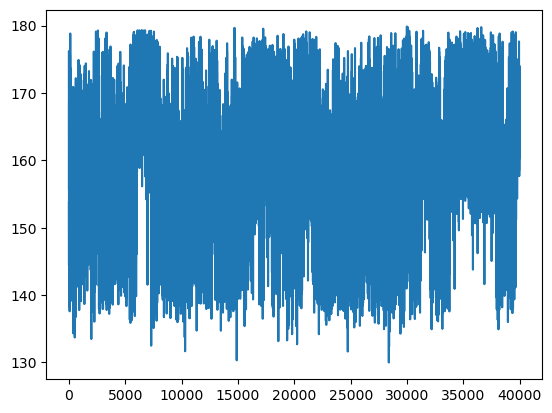

In [23]:
# plot beta angle 
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(range(euler_angles.shape[0]), euler_angles[:,2,1])

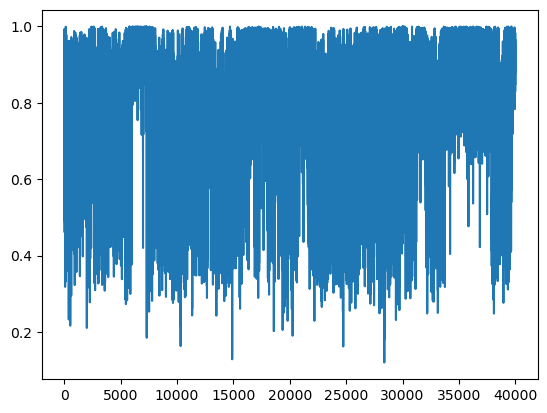

In [25]:
# plote Y2,0 

Y2_0 = 1/2*(3*np.cos(euler_angles[:,2,1]/180*np.pi)**2-1)

plt.plot(range(euler_angles.shape[0]), Y2_0)


In [84]:
print(np.mean(Y2_0))
print(np.var(Y2_0))

np.sum((Y2_0-np.mean(Y2_0))**2)/len(Y2_0)

0.7723275928055241
0.024383681922457705


0.024383681922457705

In [89]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def block_analysis (euler_angles, chain, block_size):
    if chain not in euler_angles:
        raise ValueError(f"Chain '{chain}' not found in euler_angles.")
    num_frames, num_residues=euler_angle[chain].shape
    num_blocks= num_frames/num_blocks
    
    for i in range(num_block):
        acf+= autocorrlation_sphere20(euler_angles[])
        

def autocorrelation_sphere20(euler_angles, chain):
    """
    Calculate the autocorrelation function for the Y2,0 component of CSA interactions,
    computed individually for each residue.

    Parameters:
    -----------
    euler_angles : dict
        Dictionary with chain IDs as keys and 3D numpy arrays as values.
        Each array has shape (num_frames, num_residues, 3), where the last
        dimension contains [yaw, pitch, roll] angles in degrees.
    chain : str
        Chain ID to process (e.g., 'A', 'B', etc.).

    Returns:
    --------
    acf : numpy.ndarray
        Autocorrelation function for the Y2,0 component, with shape (num_frames - 1, num_residues).
    """
    if chain not in euler_angles:
        raise ValueError(f"Chain '{chain}' not found in euler_angles.")

    # Extract pitch angle (beta) and calculate Y2,0 component
    beta = np.radians(euler_angles[chain][:, :, 1])  # Convert to radians
    cos_beta = np.cos(beta)  # Cosine of beta
    cos2 = cos_beta**2  # Squared cosine of beta
    A = (3 * cos2 - 1) / 2.0  # Y2,0 CSA interaction, shape: (num_frames, num_residues)
    print(A.shape)

    # Calculate mean over frames for each residue
    A_mean = np.mean(A, axis=0)  # Shape: (1, num_residues)
    epsilon=epsilon = 1e-10
    variance = np.var(A, axis=0) + epsilon  # Variance with added epsilon
    print(variance.shape)

    # Number of frames and residues
    num_frames, num_residues = A.shape

    # Preallocate autocorrelation array
    acf = np.zeros((num_frames , num_residues))

    # Calculate ACF
#     for k in range(1, num_frames):  # Skip k=0 (full overlap)
#         # Mean-subtracted product for each residue
#         overlap = num_frames - k  # Overlapping frames
#         acf[k - 1] = np.sum(
#             (A[:-k] - A_mean) * (A[k:] - A_mean), axis=0
#         ) / overlap

        # Handle k = 0 separately
    acf[0] = np.sum((A-A_mean)**2,axis=0)/num_frames
        
    for k in range(1, num_frames):  # Skip k=0 (full overlap)
    # Mean-subtracted product for each residue
        overlap = num_frames - k  # Overlapping frames
        acf[k] = np.sum(
            (A[:-k] - A_mean) * (A[k:] - A_mean), axis=0
        ) / overlap

    
    # Shape: (1, num_residues)
    acf /= variance

    return acf

In [90]:
# autocorrealtion function
acf = autocorrelation_sphere20(sigma_22_dict,'A')


(40001, 7)
(7,)


In [91]:
print(acf[0,:])

[0.98515654 0.95908119 0.99526768 0.99133575 0.85242083 0.99160951
 0.94610353]


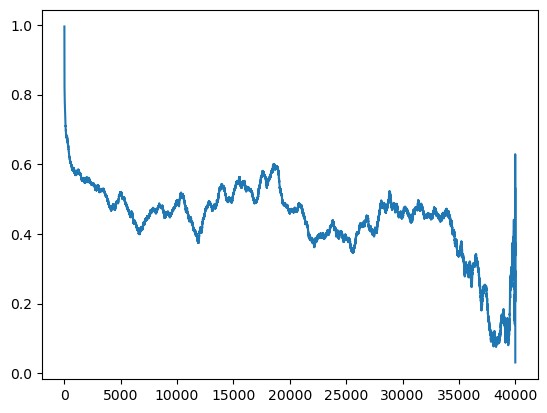

In [93]:
plt.plot(range(acf.shape[0]), acf[:,2])

In [13]:
# calcualte S2

import numpy as np

def order_parameter(angle):
    """
    Calculate the order parameter (S²) from an array of angles.

    Parameters:
    -----------
    angle : numpy.ndarray
        Array of angles (in radians) with shape (num_frames, num_residues) 
        or a 1D array for a single residue across frames.

    Returns:
    --------
    S_square : numpy.ndarray
        Array of order parameters (S²) with shape (num_residues) or a scalar 
        if input is 1D.
    """
    # Input validation
    if not isinstance(angle, np.ndarray):
        raise TypeError("Input 'angle' must be a numpy array.")
    if np.any((angle < 0) | (angle > 2 * np.pi)):
        raise ValueError("Input angles should be in radians (0 to 2π).")
    
    # Perform calculation (vectorized)
    cos_squared = np.cos(angle) ** 2
    S_square = 0.5 * np.sum(3 * cos_squared - 1, axis=0) / angle.shape[0]

    return S_square

S_square =order_parameter(euler_angles[:,:,1]/180*np.pi)

<BarContainer object of 7 artists>

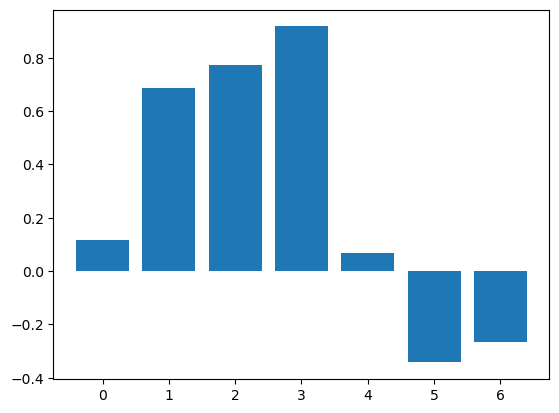

In [18]:
#plt.plot(range(euler_angles.shape[0]), S_square[:,2])
#print(S_square.shape)
plt.bar(range(7), S_square)

In [ ]:
time = KcsA_analyzer[0].data['time_ps'].to_numpy()
chain = 'A'
residue = 76
psi = KcsA_analyzer[0].data[f'{chain}:{residue}-psi'].to_numpy()
psi_cos= np.cos(psi/180*np.pi)
psi_sin= np.sin(psi/180*np.pi)
p20= 1/2 * (3*np.cos(psi/180*np.pi)**2 - 1)
p10= 2*np.cos(psi/180*np.pi)**2 - 1
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, sharex=True, figsize=(8, 6))
ax1.plot(time, psi_cos, label=f'{chain}:{residue}-psi_cos', color='blue')
ax2.plot(time, psi_sin, label=f'{chain}:{residue}-psi_sin', color='red')
ax3.plot(time, psi, label=f'{chain}:{residue}-psi', color='red')
ax4.plot(time, p10, label=f'{chain}:{residue}-p10', color='red')